# Installations and Imports

In [ ]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!sudo apt-get install -y xvfb ffmpeg
!pip3 install gymnasium[classic_control]

In [1]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility functions for rendering evironment

In [2]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [3]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [4]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_observations, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, n_actions)
        )
        # ==================================== Your Code (End) ====================================

    def forward(self, x):
        # ==================================== Your Code (Begin) ====================================
        x = self.linear_relu_stack(x)
        return x
        # ==================================== Your Code (End) ====================================

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [6]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 

# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    # ==================================== Your Code (Begin) ====================================
    with torch.no_grad():
        action_values = qnet(state).squeeze()
        return action_values.argmax()
    # ==================================== Your Code (End) ====================================

In [7]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.

def e_greedy_policy(qnet, state, current_timestep):
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * current_timestep / EPS_DECAY)
    # ==================================== Your Code (Begin) ====================================
    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    with torch.no_grad():
        action_values = qnet(state).squeeze()
        random_number = torch.rand(1).item()
        if random_number <= eps_threshold:
            return torch.randint(len(action_values), size=(1, ))
        else:
            return action_values.argmax()
    # ==================================== Your Code (End) ====================================

# Initial setup

In [34]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 75
TAU = 0.005
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "random_agent")

[swscaler @ 0x55edcdea8280] Warning: data is not aligned! This can lead to a speed loss


# Training

In [35]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)

In [36]:
num_episodes = 200
loss_fn = torch.nn.MSELoss()
episode_returns = []
episode_durations = []

for i_episode in tqdm(range(num_episodes)):

    # ==================================== Your Code (Begin) ====================================
    
    # 1. Start a new episode
    t = 0
    G = 0
    done = False
    state, info = env.reset()
    state = torch.tensor(state).to(device)
    while not done:
        
        # 2. Run the environment for 1 step using e-greedy policy
        action = e_greedy_policy(qnet=q_network, state=state, current_timestep=i_episode)
        next_state, reward, done, _, _ = env.step(action.item())
        
        # Add reward to the return
        G += reward * GAMMA ** t
        t += 1
        
        if done:
            next_state = None
        else:
            next_state = torch.tensor(next_state).to(device)
        
        # 3. Add the (state, action, next_state, reward) to replay memory
        transition = Transition(
            state=state,
            action=action,
            next_state=next_state,
            reward=reward
        )
        memory.push(transition)
        
        state = next_state
        
        if len(memory) < 2*BATCH_SIZE:
            continue
        
        # 4. Optimize your q_network for 1 iteration
        
        # 4.1 Sample one batch from replay memory
        mini_batch = memory.sample(BATCH_SIZE)
        
        # 4.2 Compute predicted state-action values using q_network
        q_values = [
            q_network(x.state)[x.action] for x in mini_batch
        ]
        
        # 4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
        with torch.no_grad():
            targets = [
                x.reward if x.next_state is None else
                x.reward  + GAMMA * target_network(x.next_state).max()
                for x in mini_batch
            ]
            
        # 4.4 Compute loss function and optimize q_network for 1 step
        loss = sum((target - q)**2 for target, q in zip(targets, q_values)) / len(q_values)
            
        optimizer.zero_grad()
        loss.backward()
        # In plac gradient clipping to avoid gradient exploding
        torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
        optimizer.step()
        
        # 5. Soft update the weights of target_network
        # θ′ ← τ θ + (1 −τ )θ′
        # θ   is q_network weights
        # θ′  is target_network weights
        target_net_state_dict = target_network.state_dict()
        q_net_state_dict = q_network.state_dict()
        for key in q_net_state_dict:
            target_net_state_dict[key] = TAU * q_net_state_dict[key] + (1-TAU) * target_net_state_dict[key]
        target_network.load_state_dict(target_net_state_dict)
        
    # 6. Keep track of the total reward for each episode to plot later
    episode_durations.append(t)
    episode_returns.append(G)
    print(f'Episode: {i_episode}, duration: {t}')
    
    # ==================================== Your Code (End) ====================================  
    
print('Complete')

  0%|          | 0/200 [00:00<?, ?it/s]

Episode: 0, duration: 20
Episode: 1, duration: 29
Episode: 2, duration: 37
Episode: 3, duration: 24
Episode: 4, duration: 26
Episode: 5, duration: 30
Episode: 6, duration: 26
Episode: 7, duration: 37
Episode: 8, duration: 20
Episode: 9, duration: 13
Episode: 10, duration: 18
Episode: 11, duration: 15
Episode: 12, duration: 21
Episode: 13, duration: 28
Episode: 14, duration: 24
Episode: 15, duration: 12
Episode: 16, duration: 13
Episode: 17, duration: 27
Episode: 18, duration: 10
Episode: 19, duration: 16
Episode: 20, duration: 25
Episode: 21, duration: 37
Episode: 22, duration: 13
Episode: 23, duration: 19
Episode: 24, duration: 16
Episode: 25, duration: 17
Episode: 26, duration: 10
Episode: 27, duration: 14
Episode: 28, duration: 11
Episode: 29, duration: 14
Episode: 30, duration: 11
Episode: 31, duration: 34
Episode: 32, duration: 10
Episode: 33, duration: 12
Episode: 34, duration: 11
Episode: 35, duration: 13
Episode: 36, duration: 14
Episode: 37, duration: 21
Episode: 38, duration:

Text(0, 0.5, 'Return')

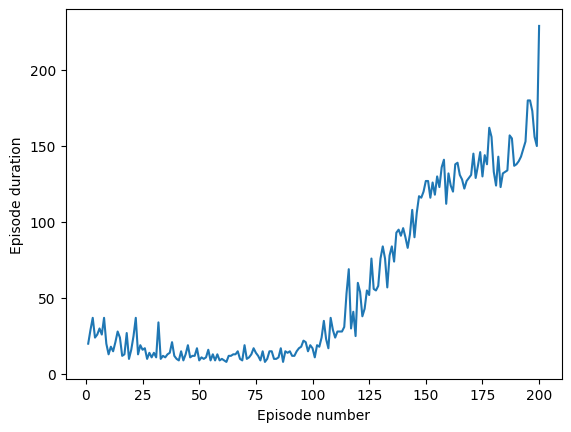

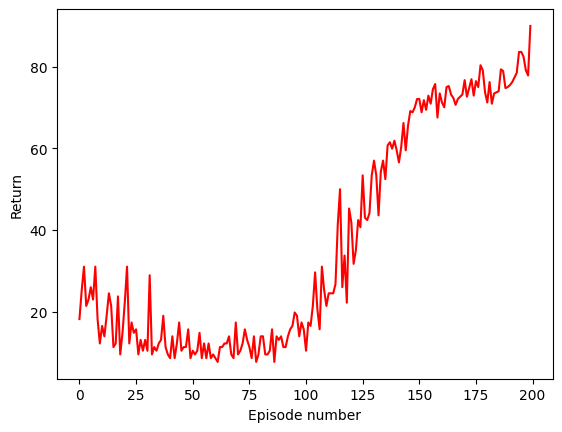

In [37]:
# Visualize the model's performance over time

fig1, ax1 = plt.subplots()
ax1.plot(range(1, num_episodes+1), episode_durations)
ax1.set_xlabel('Episode number')
ax1.set_ylabel('Episode duration')

fig2, ax2 = plt.subplots()
ax2.plot(episode_returns, color='red')
ax2.set_xlabel('Episode number')
ax2.set_ylabel('Return')

In [38]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "trained_agent")

[swscaler @ 0x55691f324280] Warning: data is not aligned! This can lead to a speed loss
